In [1]:
import json
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
file_patterns = [
    'batdongsan_details.json',
    'batdongsan_details_2.json',
    'batdongsan_details_3.json',
    'batdongsan_details_4.json',
    'batdongsan_details_5.json',
    'batdongsan_details_6.json',
    'batdongsan_details_pi.json',
    'batdongsan_details_pi_2.json',
    'batdongsan_details_pi_3.json',
    'nhatot_details_2.json',
    'nhatot_details.json']

In [3]:
def load_and_combine_json_files(file_patterns):
    all_data = []
    for pattern in file_patterns:
        try:
            with open(f'data/{pattern}', 'r', encoding='utf-8') as f:
                data = json.load(f)
                if isinstance(data, list):
                    all_data.extend(data)
                else:
                    all_data.append(data)
        except FileNotFoundError:
            print(f"File {pattern} not found.")
        except json.JSONDecodeError:
            print(f"Error decoding JSON from file {pattern}.")
    return all_data

In [4]:
data= load_and_combine_json_files(file_patterns)
with open('data/batdongsan_data.json', 'w', encoding='utf-8') as f:
    json.dump(data, f, ensure_ascii=False, indent=2)

In [5]:
def normalize_keys(data_list):
    normalized_list = []
    key_map = {
        "Tieu de": "Tiêu đề",
        "Dia chi": "Địa chỉ",
    }
    for item in data_list:
        normalized_item = {}
        for key, value in item.items():
            normalized_key = key_map.get(key, key)
            normalized_item[normalized_key] = value
        normalized_list.append(normalized_item)
    return normalized_list

In [6]:
def _parse_price(price_str, area_m2_val=None):
    if not isinstance(price_str, str):
        return None

    price_str_lower = price_str.lower()
    if "thỏa thuận" in price_str_lower:
        return {"value": None, "unit": "Thỏa thuận", "original_text": price_str}

    num_part_match = re.search(r'([\d.,]+)', price_str)
    if not num_part_match:
        return None

    num_str_cleaned = num_part_match.group(1).replace('.', '').replace(',', '.')

    try:
        num_val = float(num_str_cleaned)
    except ValueError:
        return None

    value = None
    unit = "VNĐ"
    estimated_total_value_vnd = None

    if "tỷ" in price_str_lower:
        value = num_val * 1_000_000_000
    elif "triệu/m²" in price_str_lower or \
         "tr/m²" in price_str_lower or \
         "triệu/m2" in price_str_lower:
        value = num_val * 1_000_000
        unit = "VNĐ/m²"
        if area_m2_val is not None and area_m2_val > 0:
            estimated_total_value_vnd = value * area_m2_val
    elif "triệu" in price_str_lower:
        value = num_val * 1_000_000

    if value is not None:
        result = {"value": value, "unit": unit}
        if estimated_total_value_vnd is not None:
            result["estimated_total_value_vnd"] = estimated_total_value_vnd
        return result
    return None

In [7]:
def _extract_numerical_value(text_val, unit_suffix_list=None):
    if not isinstance(text_val, str):
        return None
    cleaned_text = text_val.replace('.', '').replace(',', '.')

    if unit_suffix_list:
        for unit_suffix in unit_suffix_list:
            pattern = rf'([\d\.]+)\s*(?:{re.escape(unit_suffix)})(?:\b|$)'
            match = re.search(pattern, cleaned_text, re.IGNORECASE)
            if match:
                try:
                    return float(match.group(1))
                except ValueError:
                    continue

    first_num_match = re.search(r'([\d\.]+)', cleaned_text)
    if first_num_match:
        try:
            return float(first_num_match.group(1))
        except ValueError:
            return None
    return None

In [8]:
normalized_data = normalize_keys(data)

In [9]:
def preprocess_real_estate_data(data_list):
    processed_list = []
    for item_idx, item in enumerate(data_list):
        processed_item = {'original_index': item_idx}

        for key in ["detail_link", "Tiêu đề", "Địa chỉ", "Hướng nhà", "Hướng ban công"]:
            processed_item[key] = item.get(key)

        area_m2_val = None
        raw_area = item.get('Diện tích')
        if raw_area is not None:
            val = _extract_numerical_value(str(raw_area), ["m²", "m2"])
            if val is not None:
                processed_item['Diện tích (m2)'] = val
                area_m2_val = val
            else:
                processed_item['Diện tích (m2)'] = None
                processed_item['Diện tích_original'] = str(raw_area)
        else:
            processed_item['Diện tích (m2)'] = None

        raw_price = item.get('Mức giá')
        if raw_price is not None:
            price_info = _parse_price(str(raw_price), area_m2_val)
            if price_info:
                processed_item['Mức giá'] = price_info
            else:
                processed_item['Mức giá'] = None
                processed_item['Mức giá_original'] = str(raw_price)
        else:
            processed_item['Mức giá'] = None
        raw_value_br = item.get('Số phòng ngủ')
        if raw_value_br is not None:
            val_br = _extract_numerical_value(str(raw_value_br), ["phòng"])
            if val_br is not None:
                processed_item['Số phòng ngủ (phòng)'] = int(val_br) if val_br.is_integer() else val_br
            else:
                processed_item['Số phòng ngủ (phòng)'] = None
                processed_item['Số phòng ngủ_original'] = str(raw_value_br)
        else:
            processed_item['Số phòng ngủ (phòng)'] = None
        raw_value_bath = item.get('Số phòng tắm, vệ sinh')
        if raw_value_bath is not None:
            val_bath = _extract_numerical_value(str(raw_value_bath), ["phòng"])
            if val_bath is not None:
                processed_item['Số phòng tắm (phòng)'] = int(val_bath) if val_bath.is_integer() else val_bath
            else:
                processed_item['Số phòng tắm (phòng)'] = None
                processed_item['Số phòng tắm_original'] = str(raw_value_bath)
        else:
            processed_item['Số phòng tắm (phòng)'] = None
        raw_value_fl = item.get('Số tầng')
        if raw_value_fl is not None:
            val_fl = _extract_numerical_value(str(raw_value_fl), ["tầng"])
            if val_fl is not None:
                processed_item['Số tầng (tầng)'] = int(val_fl) if val_fl.is_integer() else val_fl
            else:
                processed_item['Số tầng (tầng)'] = None
                processed_item['Số tầng_original'] = str(raw_value_fl)
        else:
            processed_item['Số tầng_tầng'] = None

        meter_fields_map = {
            'Mặt tiền': 'Mặt tiền (m)',
            'Đường vào': 'Đường vào (m)'
        }
        for raw_key, processed_key_prefix in meter_fields_map.items():
            raw_value = item.get(raw_key)
            if raw_value is not None:
                val = _extract_numerical_value(str(raw_value), ["m"])
                if val is not None:
                    processed_item[processed_key_prefix] = val
                else:
                    processed_item[processed_key_prefix] = None
                    processed_item[f'{raw_key}_original'] = str(raw_value)
            else:
                processed_item[processed_key_prefix] = None

        raw_legal = item.get('Pháp lý')
        if raw_legal is not None:
            legal_status = str(raw_legal).strip().rstrip('.')
            processed_item['Pháp lý'] = legal_status
        else:
            processed_item['Pháp lý'] = None

        raw_furniture = item.get('Nội thất')
        if raw_furniture is not None:
            furniture_status = str(raw_furniture).strip().rstrip('.')
            processed_item['Nội thất'] = furniture_status
            furniture_lower = furniture_status.lower()
            if furniture_lower == "không nội thất":
                processed_item['Nội thất trống'] = True
            elif furniture_lower == "đầy đủ":
                 processed_item['Nội thất đầy đủ'] = True
            elif furniture_lower == "cơ bản":
                 processed_item['Nội thất cơ bản'] = True
        else:
            processed_item['Nội thất'] = None

        processed_list.append(processed_item)
    return processed_list

In [10]:
processed_data = preprocess_real_estate_data(normalized_data)

In [11]:
df = pd.DataFrame(processed_data)
df

,original_index,detail_link,Tiêu đề,Địa chỉ,Hướng nhà,Hướng ban công,Diện tích (m2),Mức giá,Số phòng ngủ (phòng),Số phòng tắm (phòng),Số tầng_tầng,Mặt tiền (m),Đường vào (m),Pháp lý,Nội thất,Nội thất đầy đủ,Số tầng (tầng),Nội thất cơ bản,Nội thất trống,Mức giá_original
0,0,https://batdongsan.com.vn/ban-can-ho-chung-cu-...,"Tiết kiệm lớn DK chỉ 400 triệu, nhận ngay chiế...","Dự án The Paris - Vinhomes Ocean Park, Đường L...",Đông - Bắc,Tây - Nam,65.0,"{'value': None, 'unit': 'Thỏa thuận', 'origina...",2.0,2.0,NaN,NaN,NaN,Hợp đồng mua bán,None,NaN,NaN,NaN,NaN,NaN
1,1,https://batdongsan.com.vn/ban-dat-xa-song-phuo...,Đất thổ cư Song Phương sát Đại Lộ Thăng Long đ...,"Xã Song Phương, Hoài Đức, Hà Nội",Bắc,None,66.0,"{'value': 120000000.0, 'unit': 'VNĐ/m²', 'esti...",NaN,NaN,NaN,5.4,6.0,Sổ đỏ/ Sổ hồng,None,NaN,NaN,NaN,NaN,NaN
2,2,https://batdongsan.com.vn/ban-can-ho-chung-cu-...,"Chính chủ cần bán căn góc 2PN + 1, 2WC tòa S2 ...","Dự án The Sapphire 2 - Vinhomes Ocean Park, Xã...",None,None,67.9,"{'value': 3450000000.0, 'unit': 'VNĐ'}",2.0,2.0,NaN,NaN,NaN,Sổ đỏ/ Sổ hồng,Đầy đủ,True,NaN,NaN,NaN,NaN
3,3,https://batdongsan.com.vn/ban-nha-rieng-duong-...,Bán nhà Tây Sơn - Thịnh Quang 148m2*Mặt tiền 8...,"Đường Tây Sơn, Phường Thịnh Quang, Đống Đa, H...",Đông - Bắc,Đông - Bắc,98.0,"{'value': 18900000000.0, 'unit': 'VNĐ'}",6.0,4.0,NaN,8.0,3.0,Sổ đỏ/ Sổ hồng,Cơ bản,NaN,4.0,True,NaN,NaN
4,4,https://batdongsan.com.vn/ban-can-ho-chung-cu-...,Quỹ căn siêu đẹp từ studio/1PN - 2 - 3PN tại V...,"Dự án Vinhomes Ocean Park Gia Lâm, Xã Dương Xá...",None,None,43.0,"{'value': 2340000000.0, 'unit': 'VNĐ'}",1.0,1.0,NaN,NaN,NaN,Sổ đỏ/ Sổ hồng,None,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19775,19775,None,Ô tô vào nhà - Bán Siêu phẩm nhà Nam Từ Liêm -...,"Đường Phương Canh, Phường Phương Canh, Quận Na...",None,None,NaN,None,4.0,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,NaN
19776,19776,None,Bán nhà Khương Hạ TX - 32m2 - giá 3.05 tỷ - 2...,"Phố Khương Hạ, Phường Khương Đình, Quận Thanh ...",None,None,NaN,None,2.0,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,NaN
19777,19777,None,5TẦNG THANG MÁY MẶT NGÕ THÔNG ÔTÔ VÀO NHÀ TT P...,"Đường Bát Khối, Phường Cự Khối, Quận Long Biên...",None,None,NaN,None,3.0,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,NaN
19778,19778,None,Trung tâm P. Cự Khối 4tầng 4pn rộng rãi và tho...,"Đường Bát Khối, Phường Cự Khối, Quận Long Biên...",None,None,NaN,None,4.0,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN,NaN,NaN


In [12]:
df = df.drop_duplicates(subset=['detail_link'], keep='first')

In [13]:
df

,original_index,detail_link,Tiêu đề,Địa chỉ,Hướng nhà,Hướng ban công,Diện tích (m2),Mức giá,Số phòng ngủ (phòng),Số phòng tắm (phòng),Số tầng_tầng,Mặt tiền (m),Đường vào (m),Pháp lý,Nội thất,Nội thất đầy đủ,Số tầng (tầng),Nội thất cơ bản,Nội thất trống,Mức giá_original
0,0,https://batdongsan.com.vn/ban-can-ho-chung-cu-...,"Tiết kiệm lớn DK chỉ 400 triệu, nhận ngay chiế...","Dự án The Paris - Vinhomes Ocean Park, Đường L...",Đông - Bắc,Tây - Nam,65.0,"{'value': None, 'unit': 'Thỏa thuận', 'origina...",2.0,2.0,NaN,NaN,NaN,Hợp đồng mua bán,None,NaN,NaN,NaN,NaN,NaN
1,1,https://batdongsan.com.vn/ban-dat-xa-song-phuo...,Đất thổ cư Song Phương sát Đại Lộ Thăng Long đ...,"Xã Song Phương, Hoài Đức, Hà Nội",Bắc,None,66.0,"{'value': 120000000.0, 'unit': 'VNĐ/m²', 'esti...",NaN,NaN,NaN,5.4,6.0,Sổ đỏ/ Sổ hồng,None,NaN,NaN,NaN,NaN,NaN
2,2,https://batdongsan.com.vn/ban-can-ho-chung-cu-...,"Chính chủ cần bán căn góc 2PN + 1, 2WC tòa S2 ...","Dự án The Sapphire 2 - Vinhomes Ocean Park, Xã...",None,None,67.9,"{'value': 3450000000.0, 'unit': 'VNĐ'}",2.0,2.0,NaN,NaN,NaN,Sổ đỏ/ Sổ hồng,Đầy đủ,True,NaN,NaN,NaN,NaN
3,3,https://batdongsan.com.vn/ban-nha-rieng-duong-...,Bán nhà Tây Sơn - Thịnh Quang 148m2*Mặt tiền 8...,"Đường Tây Sơn, Phường Thịnh Quang, Đống Đa, H...",Đông - Bắc,Đông - Bắc,98.0,"{'value': 18900000000.0, 'unit': 'VNĐ'}",6.0,4.0,NaN,8.0,3.0,Sổ đỏ/ Sổ hồng,Cơ bản,NaN,4.0,True,NaN,NaN
4,4,https://batdongsan.com.vn/ban-can-ho-chung-cu-...,Quỹ căn siêu đẹp từ studio/1PN - 2 - 3PN tại V...,"Dự án Vinhomes Ocean Park Gia Lâm, Xã Dương Xá...",None,None,43.0,"{'value': 2340000000.0, 'unit': 'VNĐ'}",1.0,1.0,NaN,NaN,NaN,Sổ đỏ/ Sổ hồng,None,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14505,14505,https://batdongsan.com.vn/ban-nha-rieng-duong-...,"Bán nhà Nguyễn Văn Cừ, Long Biên 80m2 6T 19.5 ...","Đường Nguyễn Văn Cừ, Phường Bồ Đề, Long Biên, ...",None,None,80.0,"{'value': 19500000000.0, 'unit': 'VNĐ'}",4.0,3.0,NaN,NaN,NaN,Sổ đỏ/ Sổ hồng,Đầy đủ full nội thất xịn xò,NaN,6.0,NaN,NaN,NaN
14506,14506,https://batdongsan.com.vn/ban-nha-rieng-duong-...,"Bán Nhà Hoàng Như Tiếp, Long Biên 45m2 4T 9.5 ...","Đường Hoàng Như Tiếp, Phường Bồ Đề, Long Biên,...",None,None,45.0,"{'value': 9500000000.0, 'unit': 'VNĐ'}",4.0,3.0,NaN,NaN,NaN,Sổ đỏ/ Sổ hồng,None,NaN,4.0,NaN,NaN,NaN
14507,14507,https://batdongsan.com.vn/ban-can-ho-chung-cu-...,CT4 Vimeco BigC - Chính chủ bán căn góc 148m2 ...,"Dự án CT4 Vimeco II, Đường Nguyễn Chánh, Phườn...",None,None,148.0,"{'value': 85000000.0, 'unit': 'VNĐ/m²', 'estim...",4.0,2.0,NaN,NaN,NaN,Sổ đỏ/ Sổ hồng,Cơ bản,NaN,NaN,True,NaN,NaN
14508,14508,https://batdongsan.com.vn/ban-nha-rieng-duong-...,Bán gấp nhà phân lô Đền Lừ - oto tránh vỉa hè ...,"Đường Đền Lừ, Phường Hoàng Văn Thụ, Hoàng Mai,...",None,None,40.0,"{'value': 13900000000.0, 'unit': 'VNĐ'}",4.0,NaN,NaN,5.8,7.0,Sổ đỏ/ Sổ hồng,Đầy đủ,True,5.0,NaN,NaN,NaN


In [14]:
df.to_csv('data/batdongsan_processed_data.csv', index=False, encoding='utf-8-sig')

In [15]:
cols_for_boxplot = [
    'Diện tích (m2)',
    'Mức giá (VNĐ)',
    'Số phòng ngủ (phòng)',
    'Số phòng tắm (phòng)',
    'Số tầng (tầng)',
    'Mặt tiền (m)',
    'Đường vào (m)'
]

C:\Users\Administrator\AppData\Local\Temp\ipykernel_14368\3640071188.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Mức giá (VNĐ)'] = df['Mức giá'].apply(lambda x: x.get('value') if isinstance(x, dict) else np.nan)


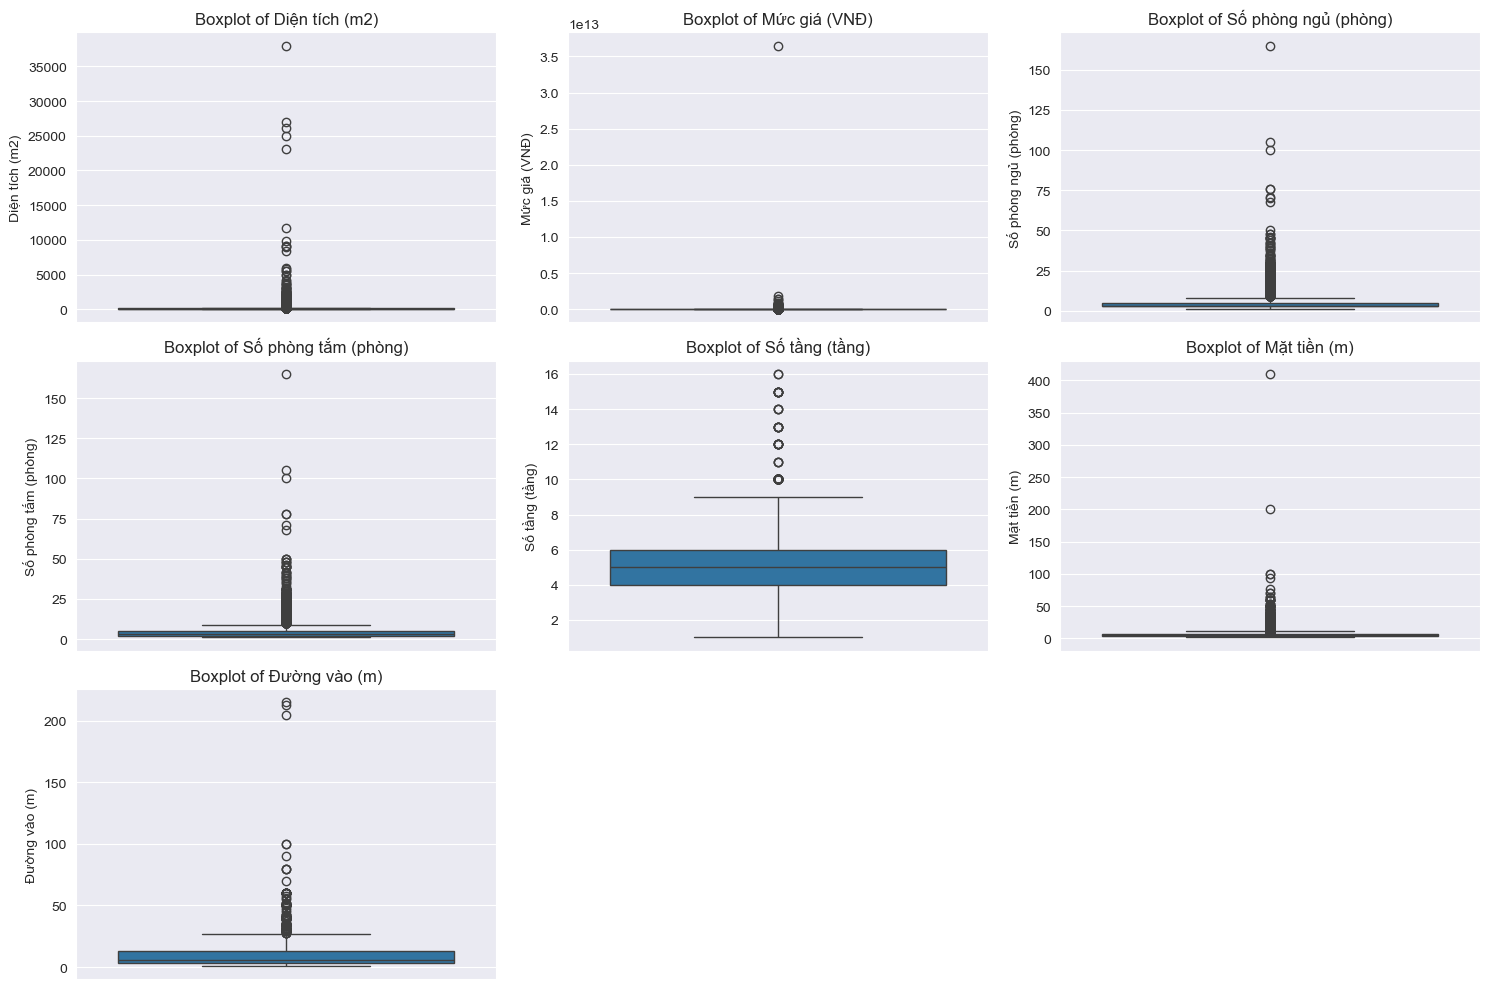

In [16]:
if 'Mức giá (VNĐ)' not in df.columns or df['Mức giá (VNĐ)'].isnull().all():
    df['Mức giá (VNĐ)'] = df['Mức giá'].apply(lambda x: x.get('value') if isinstance(x, dict) else np.nan)
plt.figure(figsize=(15, 10)) # Adjust figure size as needed
for i, col in enumerate(cols_for_boxplot):
    if col in df.columns:
        plt.subplot(3, 3, i + 1) 
        sns.boxplot(y=df[col].dropna())
        plt.title(f'Boxplot of {col}')
        plt.ylabel(col)
    else:
        print(f"Column '{col}' not found in DataFrame. Skipping boxplot.")

plt.tight_layout()
plt.show()

In [18]:

cols_for_outlier_removal = [
        'Diện tích (m2)',
        'Mức giá (VNĐ)',
        'Số phòng ngủ (phòng)',
        'Số phòng tắm (phòng)',
        'Số tầng (tầng)',
        'Mặt tiền (m)',
        'Đường vào (m)'
]

print(f"Original number of rows: {len(df)}")
df_cleaned = df.copy()

for col_name in cols_for_outlier_removal:
    if col_name not in df_cleaned.columns:
        print(f"Column '{col_name}' not found for outlier removal. Skipping.")
        continue
    numeric_col = pd.to_numeric(df_cleaned[col_name], errors='coerce')
    valid_data = numeric_col.dropna()
    if valid_data.empty:
        print(f"Column '{col_name}' has no valid numeric data after coercion and dropping NaNs. Skipping outlier removal for this column.")
        continue

    Q1 = valid_data.quantile(0.25)
    Q3 = valid_data.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    print(f"\nOutlier detection for column: {col_name}")
    print(f"  Q1: {Q1}, Q3: {Q3}, IQR: {IQR}")
    print(f"  Lower bound: {lower_bound}, Upper bound: {upper_bound}")
    outliers_mask = (numeric_col.notna()) & ((numeric_col < lower_bound) | (numeric_col > upper_bound))
    num_outliers = outliers_mask.sum()
    print(f"  Number of outliers detected in '{col_name}': {num_outliers}")
    df_cleaned = df_cleaned[~outliers_mask]
    print(f"  Number of rows after removing outliers for '{col_name}': {len(df_cleaned)}")
print(f"\nTotal number of rows after outlier removal: {len(df_cleaned)}")
print(f"Total rows removed: {len(df) - len(df_cleaned)}")

Original number of rows: 14371

Outlier detection for column: Diện tích (m2)
  Q1: 50.0, Q3: 109.0, IQR: 59.0
  Lower bound: -38.5, Upper bound: 197.5
  Number of outliers detected in 'Diện tích (m2)': 1241
  Number of rows after removing outliers for 'Diện tích (m2)': 13130

Outlier detection for column: Mức giá (VNĐ)
  Q1: 5100000000.0, Q3: 16899999999.999998, IQR: 11799999999.999998
  Lower bound: -12599999999.999996, Upper bound: 34599999999.99999
  Number of outliers detected in 'Mức giá (VNĐ)': 972
  Number of rows after removing outliers for 'Mức giá (VNĐ)': 12158

Outlier detection for column: Số phòng ngủ (phòng)
  Q1: 2.0, Q3: 4.0, IQR: 2.0
  Lower bound: -1.0, Upper bound: 7.0
  Number of outliers detected in 'Số phòng ngủ (phòng)': 617
  Number of rows after removing outliers for 'Số phòng ngủ (phòng)': 11541

Outlier detection for column: Số phòng tắm (phòng)
  Q1: 2.0, Q3: 4.0, IQR: 2.0
  Lower bound: -1.0, Upper bound: 7.0
  Number of outliers detected in 'Số phòng tắm (

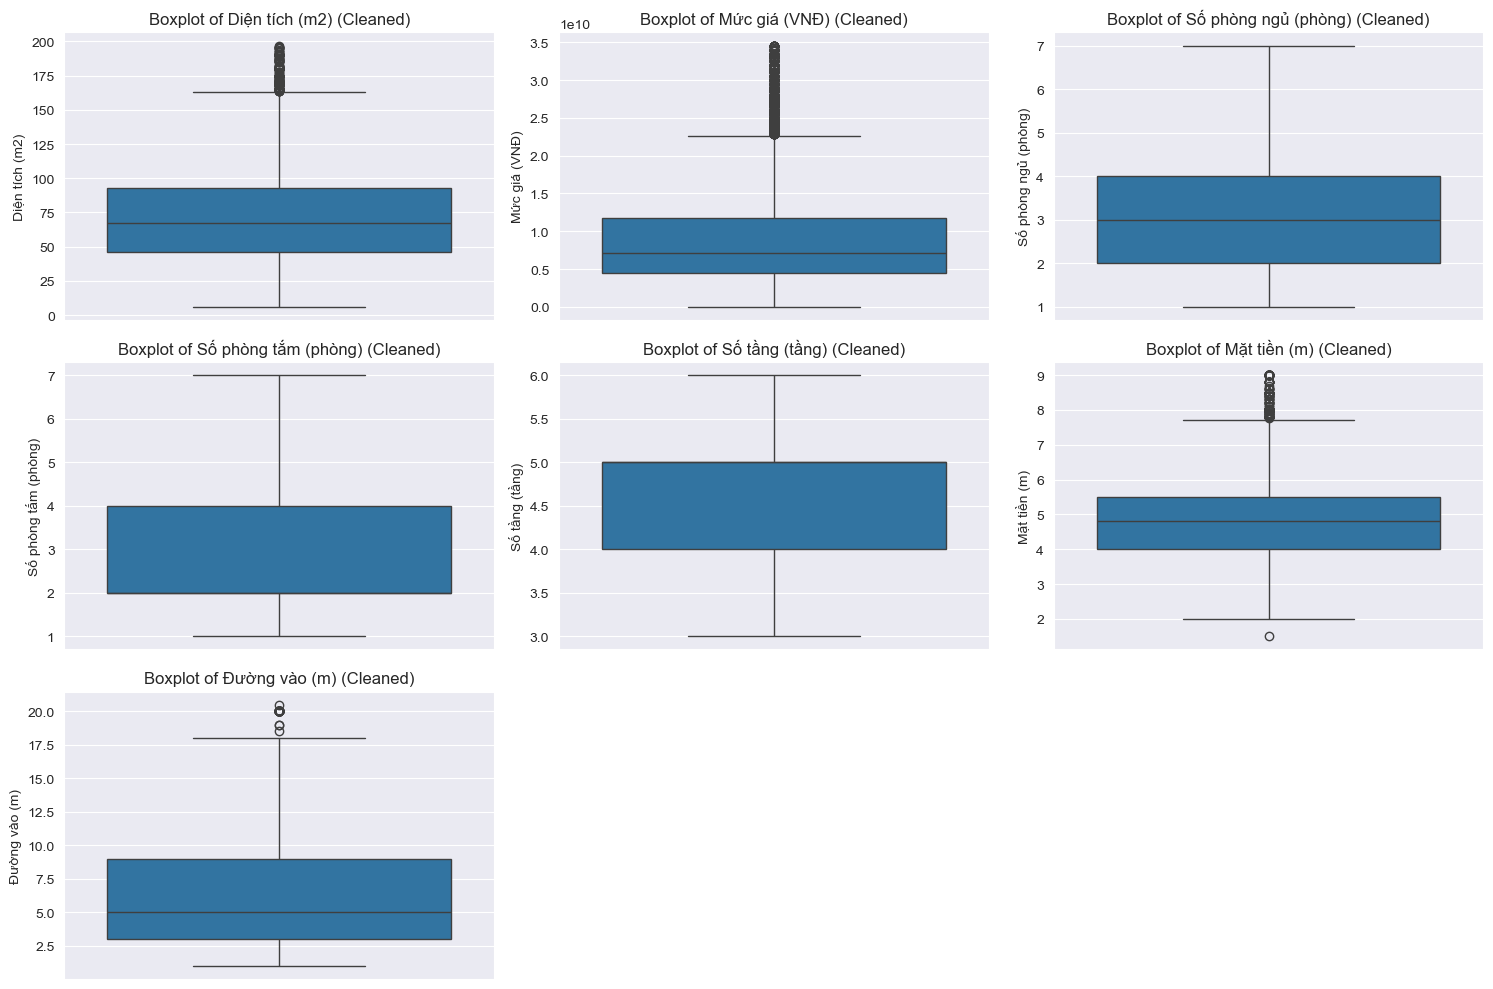

In [19]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(cols_for_boxplot):
    if col in df_cleaned.columns:
        plt.subplot(3, 3, i + 1)
        data_to_plot = pd.to_numeric(df_cleaned[col], errors='coerce').dropna()
        if not data_to_plot.empty:
            sns.boxplot(y=data_to_plot)
            plt.title(f'Boxplot of {col} (Cleaned)')
            plt.ylabel(col)
        else:
            plt.title(f'Boxplot of {col} (No data)')
            plt.ylabel(col)
    else:
        print(f"Column '{col}' not found in DataFrame. Skipping boxplot.")

plt.tight_layout()
plt.show()

In [20]:
df_cleaned.to_csv('data/batdongsan_processed_data_cleaned.csv', index=False, encoding='utf-8-sig')

print("Cleaned data saved to 'data/batdongsan_processed_data_cleaned.csv'")

Cleaned data saved to 'data/batdongsan_processed_data_cleaned.csv'
